# Playoff Predictor: Using a Neural Network to Forecast Goals per Game in the NHL Postseason

This project began out of curiosity as opposed to any desire for a formal investigation. Along the way, it grew into something that I felt deserved slightly more exposition, so this is the result. 

With the upsurgence of sports betting sponsorships in professional sports leagues also comes an upsurgence in the ridiculousness of welcome offers that sports betting sites are willing to give. With offers ranging from doubling, to quadrupling your first deposit, it's never been a better time to wager with other people's money. My goal here is not necessarily to make money. I know that, in spite of my best efforts, the odds will not be in my favour (the house always wins, so to speak). My goal in betting is to stretch out those free plays for as long as possible. 

While I began (as I think most betters do) by trying to pick the winner of each game, my attention was quickly drawn to the props (bets not tied to the final outcome). The average number of goals scored per game varies from season to season, but in 2023 it was the highest it's been in 30-years; almost 6.5. Off the top of my head, I would have said that 70% of games probably end with 5-8 total goals scored, which made the 4.5:1, 8:1, 4.5:1, and 10:1 odds being offered on 5, 6, 7, and 8 total goals seem very attractive. As a prudent data scientist, however, I wanted to check my assumptions before acting on them. 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (metrics, neural_network, preprocessing, pipeline)
from sklearn.model_selection import cross_val_score
import patsy

NHL game data obtained from https://www.hockey-reference.com/leagues/

First, how many games this season actually ended with 5, 6, 7, or 8 total goals? 

In [19]:
nhl_2022_reg = pd.read_csv('nhl2022_reg.csv').set_index("Date")
nhl_2022_reg['total_goals'] = nhl_2022_reg['G'] + nhl_2022_reg['G.1']
percent_values = nhl_2022_reg['total_goals'].value_counts() / sum(nhl_2022_reg['total_goals'].value_counts())
print(percent_values)

7     0.215701
5     0.214177
9     0.111280
6     0.109756
3     0.098323
8     0.087652
4     0.071646
11    0.031250
10    0.026677
1     0.009909
13    0.008384
2     0.008384
12    0.004573
14    0.001524
17    0.000762
Name: total_goals, dtype: float64


So the sum of 5, 6, 7, and 8 goal games is lower than I expected. But this is data from the regular season. It also begs the question of whether or not that's representative of what happens in the playoffs. 

It's commonly thought that scoring decreases in the playoffs (teams play more conservatively with more on the line, refs call less penalties for fear of influencing the outcome...). But again, that assumption is easy enough to validate. 

I'll want to check the average scoring, but also the distribution of goals if that's what I'm going to be betting on. 

In [25]:
def regular_season_vs_playoff_scoring(reg_season_csv, playoff_csv, year):
    """
    Plot regular season vs playoff gpg data for a given season. 
    
    Generates two plots stacked vertically, one for the average gpg, and the other for the distribution.
    """
    
    def import_and_get_metrics(reg_season_csv, playoff_csv):
        
        nhl_reg = pd.read_csv(reg_season_csv).set_index("Date")
        nhl_plf = pd.read_csv(playoff_csv).set_index("Date")
        nhl_reg["total_goals"] = nhl_reg["G"] + nhl_reg["G.1"]
        nhl_plf["total_goals"] = nhl_plf["G"] + nhl_plf["G.1"]
        
        return nhl_reg, nhl_plf
    
    nhl_reg, nhl_plf = import_and_get_metrics(reg_season_csv, playoff_csv)
    
    fig, ax = plt.subplots(2, figsize=(12,12))
    
    def plot_gpg_averages(nhl_reg, nhl_plf, year, ax):
    
        #get metrics
        reg_mean = nhl_reg["total_goals"].mean()
        reg_std = nhl_reg["total_goals"].std()
        plf_mean = nhl_plf["total_goals"].mean()
        plf_std = nhl_plf["total_goals"].std()

        #plot gpg average
        ax.bar(x='Regular Season', height=reg_mean, yerr=reg_std)
        ax.bar(x='Playoff', height=plf_mean, yerr=plf_std)
        ax.text('Regular Season', reg_mean + 0.1, f'{reg_mean:.2f}', ha='right', va='bottom')
        ax.text('Playoff', plf_mean + 0.1, f'{plf_mean:.2f}', ha='right', va='bottom')
        ax.set_ylabel('Average goals per game')
        ax.set_title(f'{year} Playoff vs Regular Season Average GPG')
    
    plot_gpg_averages(nhl_reg, nhl_plf, year, ax[0])
    
    def plot_gpg_distribution(nhl_reg, nhl_plf, year, ax):
        
        #get metrics
        reg_vals = nhl_reg['total_goals'].value_counts().sort_index()/len(nhl_reg['total_goals'])
        plf_vals = nhl_plf['total_goals'].value_counts().sort_index()/len(nhl_plf['total_goals'])

        #plot gpg distribution
        ax.bar(x = reg_vals.index-0.2, height=reg_vals.values, label='Regular Season', width=0.4)
        ax.bar(x = plf_vals.index+0.2, height=plf_vals.values, label='Playoffs', width=0.4)
        diff_thresh = 0.03 #
        for i, (reg_val, plf_val) in enumerate(zip(reg_vals.values, plf_vals.values)):
            diff = plf_val - reg_val
            if abs(diff) > diff_thresh:
                ax.annotate('*', xy=(i+1, 0.001), ha='center', weight='bold', fontsize=18)
        ax.set_xticks(range(1,max(nhl_reg['total_goals'].max(), nhl_plf['total_goals'].max())+1))
        ax.set_xlabel('Goals Per Game')
        ax.set_ylabel('Percentage of Games')
        ax.set_title(f'{year} Playoff vs Regular Season Goals Per Game Distribution')
        ax.legend()
        ax.annotate("* indicates a > 3% difference", xy=(0.77,0.8), xycoords='axes fraction', ha='left', va='top')
        
    plot_gpg_distribution(nhl_reg, nhl_plf, year, ax[1])

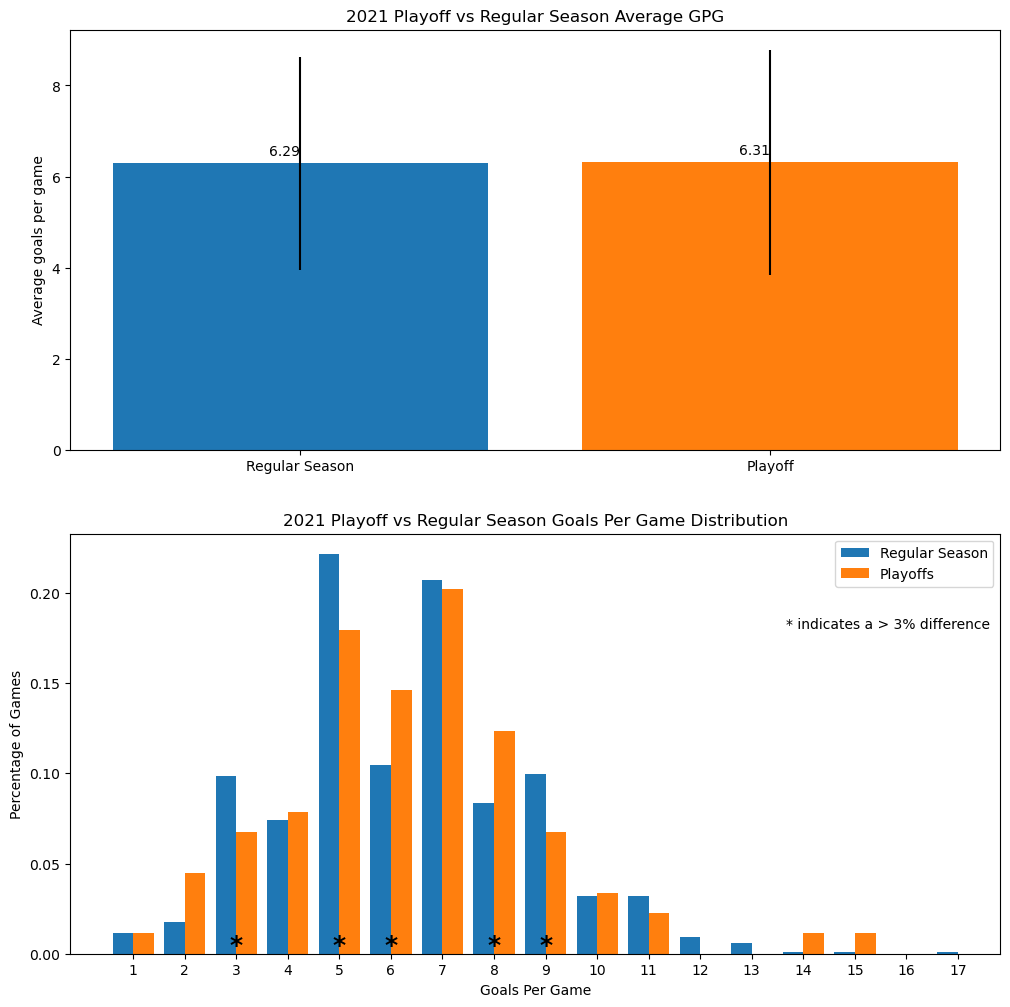

In [26]:
regular_season_vs_playoff_scoring('nhl2021_reg.csv', 'nhl2021_plf.csv', 2021)

In 2021, mean gpg in the regular season vs playoffs are approximately equal. 

The regular season had more 3, 5, and 9 goal games, whereas the playoffs had more 6 and 8 goal games. All other goal totals were approximately equal. 

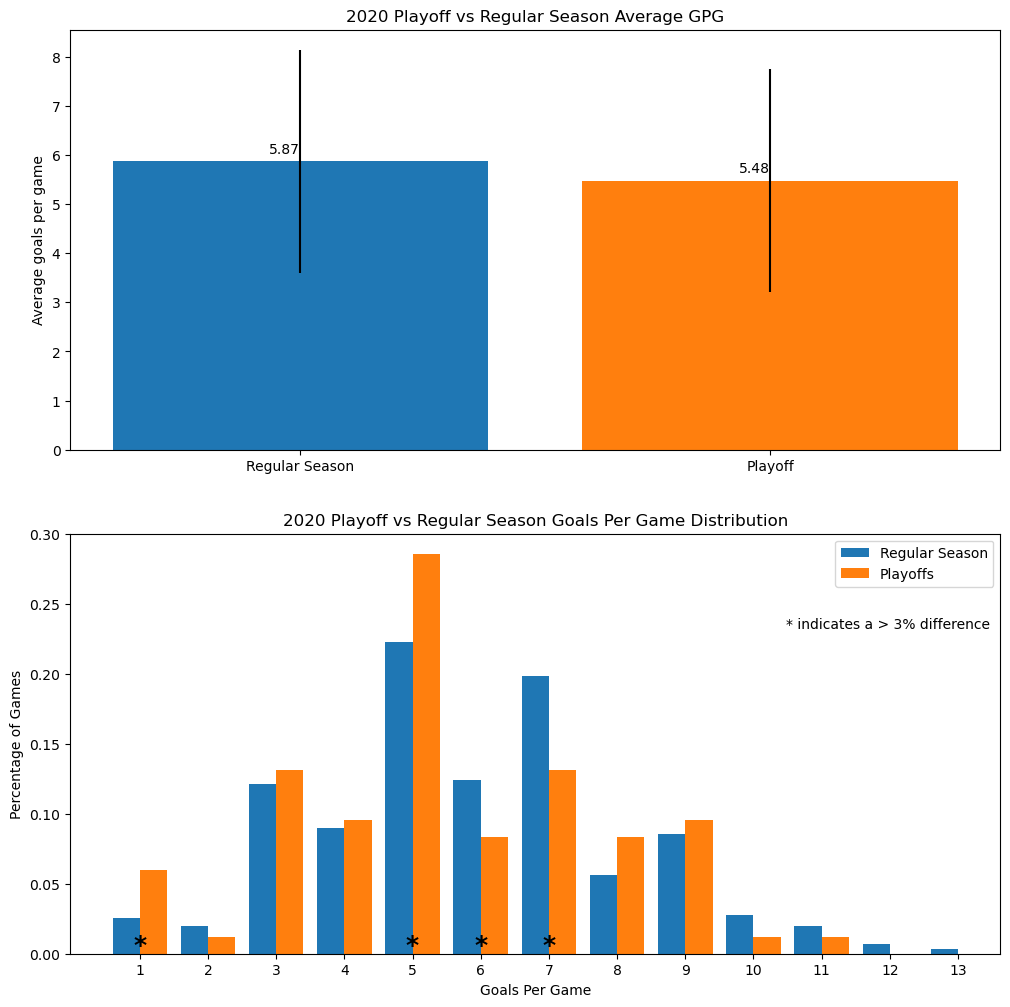

In [27]:
regular_season_vs_playoff_scoring('nhl2020_reg.csv', 'nhl2020_plf.csv', 2020)

In 2020, the playoffs had slightly lower scoring than the regular season (a difference of ~0.4gpg).

The regular season had more 6 and 7 goal games, while the playoffs had more 1 and 5 goal games. 

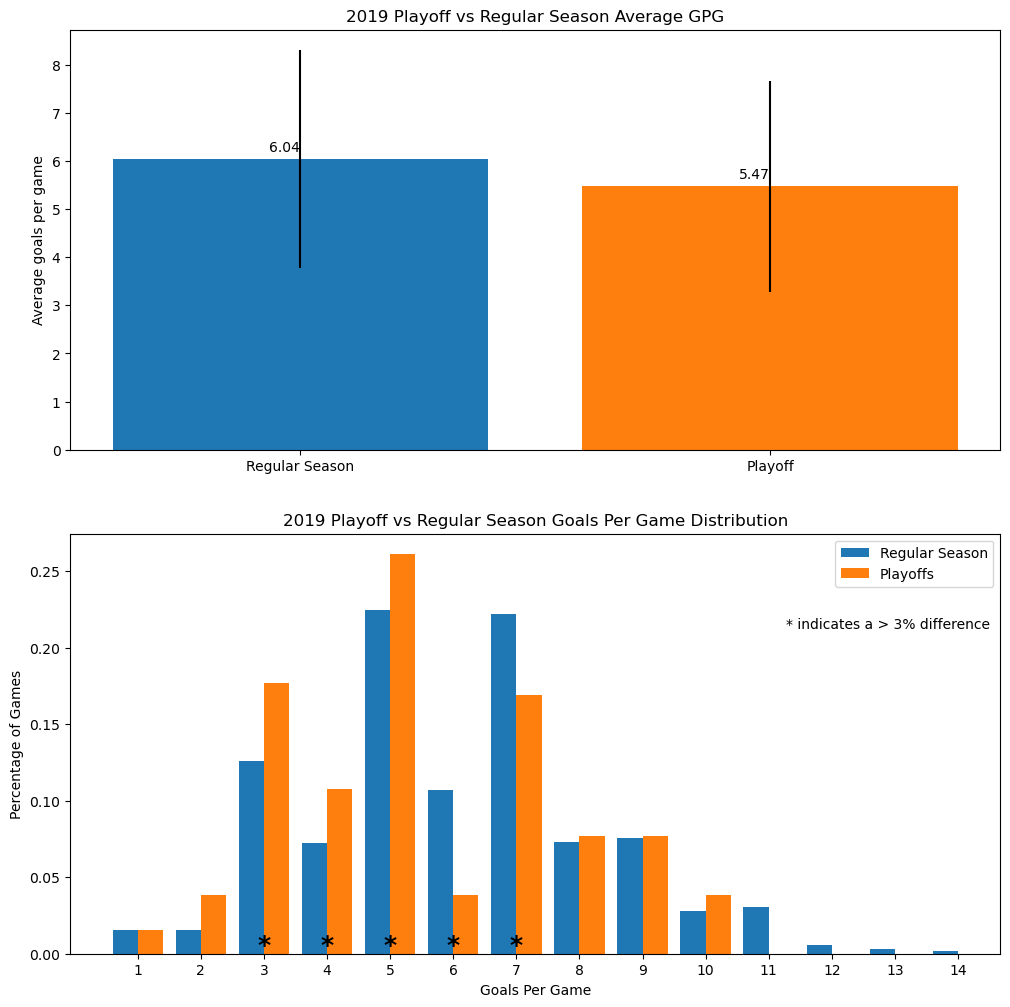

In [28]:
regular_season_vs_playoff_scoring('nhl2019_reg.csv', 'nhl2019_plf.csv', 2019)

In 2019, the playoffs had lower scoring than the regular season (a difference of ~0.6gpg).

The regular season had more 6 and 7 goal games, while the playoffs had more 3, 4, and 5 goal games. 

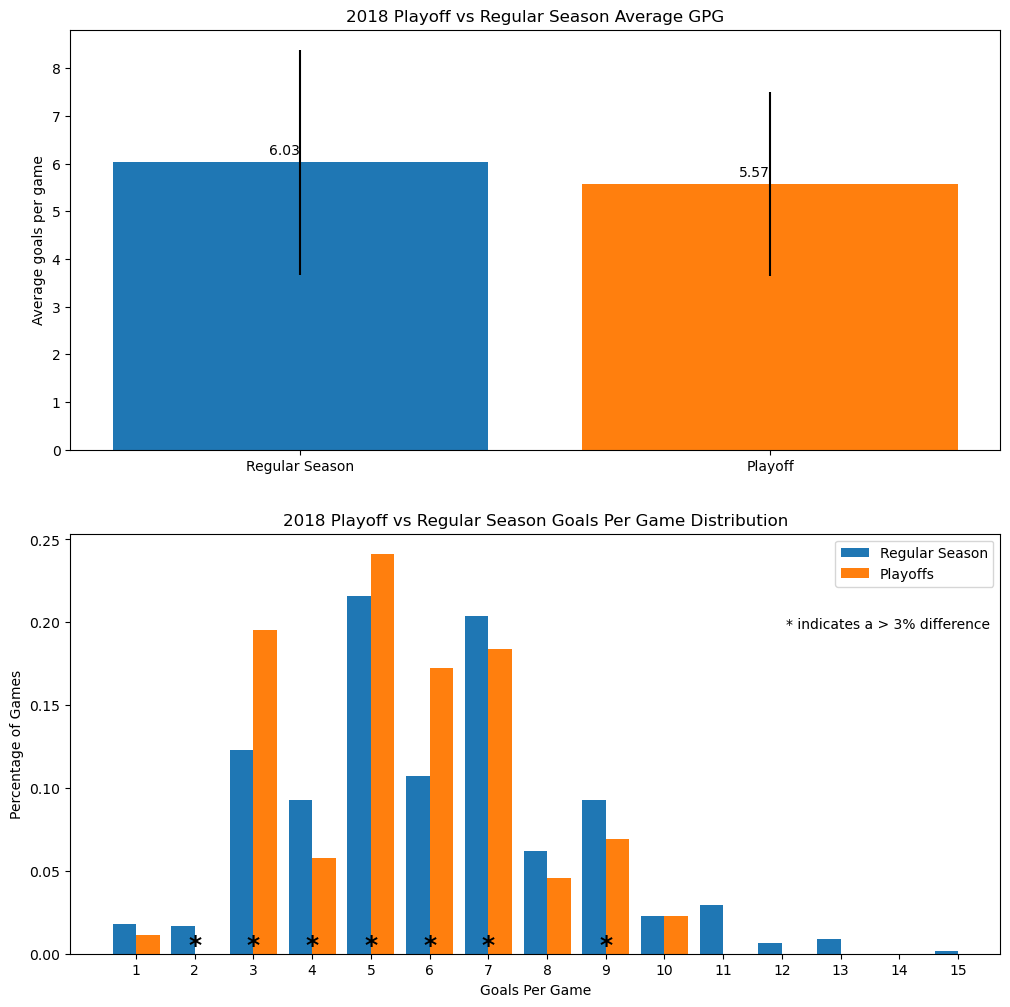

In [29]:
regular_season_vs_playoff_scoring('nhl2018_reg.csv', 'nhl2018_plf.csv', 2018)

In 2018, the playoffs had lower scoring than the regular season (a difference of ~0.5gpg).

The regular season had more 2, 4, 7, and 9 goal games, while the playoffs had more 3, 5, and 6 goal games. 

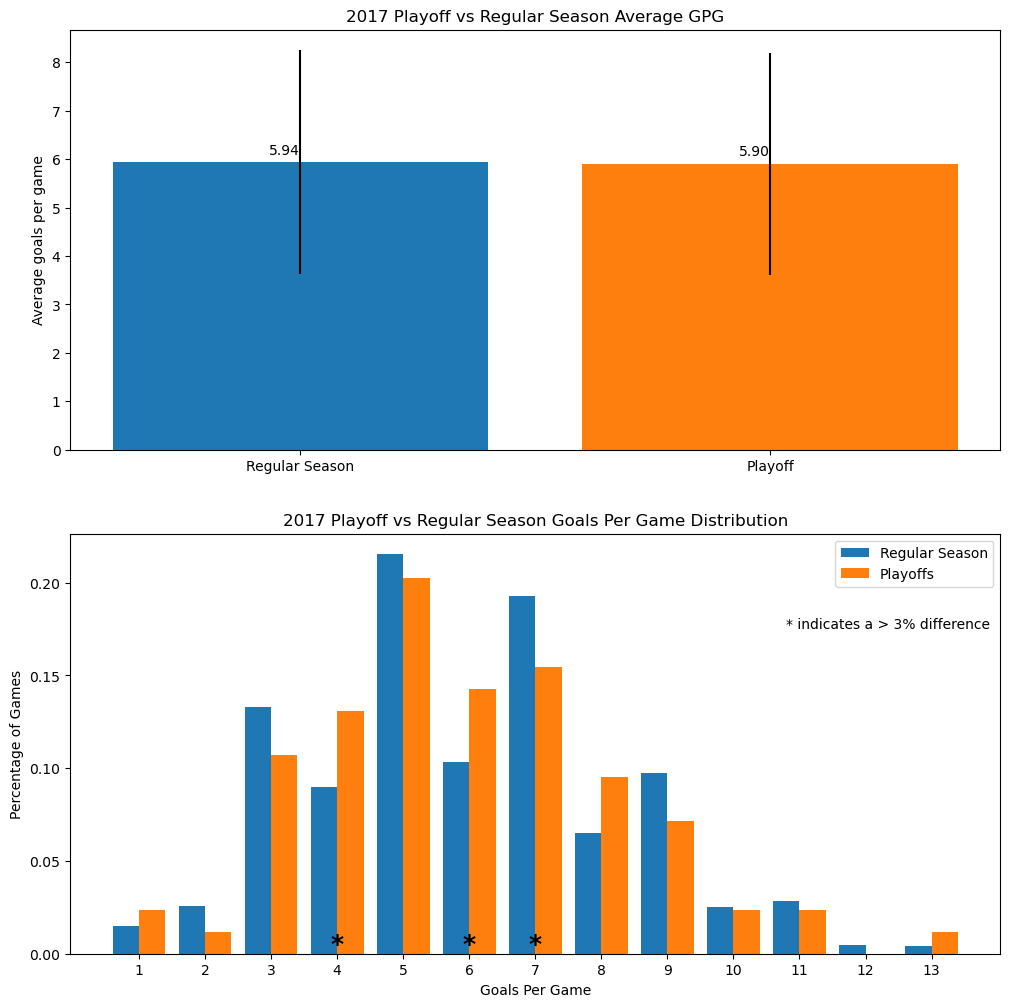

In [30]:
regular_season_vs_playoff_scoring('nhl2017_reg.csv', 'nhl2017_plf.csv', 2017)

In 2017, mean gpg in the regular season vs playoffs are approximately equal. 

The regular season had more 7 goal games, while the playoffs had more 4 and 6 goal games. 

Overall, in the past 5 years the difference between playoff and regular season scoring has been negligible in two years, and there was lower playoff scoring by around 0.5gpg in the other three. 

The the regular season had 3% more 7-goal games in 4/5 years. There is no conclusive trend in the frequency of other gpg values. 

It's not overwhelmingly conclusive that playoff scoring differs from the regular season. Sample size likely plays a role in the differences, but I don't see an obvious scaling factor that can be applied to regular season scoring in order to relate it to playoff scoring. 

## Modelling on this year's data

If I can't simply scale this year's regular season scoring to predict this year's playoff scoring, maybe I can create a model that can. 

I decided to use the past 5 seasons of regular season and playoff data to train a neural network to predict the number of total goals. Based on the results above, I decided it would be wise to add a boolean column representing whether the game was a playoff game or not. 

In [31]:
nhl_2022_reg = pd.read_csv('nhl2022_reg.csv').set_index("Date")
nhl_2021_reg = pd.read_csv('nhl2021_reg.csv').set_index("Date")
nhl_2020_reg = pd.read_csv('nhl2020_reg.csv').set_index("Date")
nhl_2019_reg = pd.read_csv('nhl2019_reg.csv').set_index("Date")
nhl_2018_reg = pd.read_csv('nhl2018_reg.csv').set_index("Date")
nhl_2017_reg = pd.read_csv('nhl2017_reg.csv').set_index("Date")

regs = [nhl_2022_reg, nhl_2021_reg, nhl_2020_reg, nhl_2019_reg, nhl_2018_reg, nhl_2017_reg]

nhl_2021_plf = pd.read_csv('nhl2021_plf.csv').set_index("Date")
nhl_2020_plf = pd.read_csv('nhl2020_plf.csv').set_index("Date")
nhl_2019_plf = pd.read_csv('nhl2019_plf.csv').set_index("Date")
nhl_2018_plf = pd.read_csv('nhl2018_plf.csv').set_index("Date")
nhl_2017_plf = pd.read_csv('nhl2017_plf.csv').set_index("Date")

plfs = [nhl_2021_plf, nhl_2020_plf, nhl_2019_plf, nhl_2018_plf, nhl_2017_plf]

nhl_full = pd.DataFrame()

for dataset in regs:
    dataset['playoffs'] = False
    nhl_full = pd.concat([nhl_full, dataset])

for dataset in plfs:
    dataset['playoffs'] = True
    nhl_full = pd.concat([nhl_full, dataset])
    
nhl_full = nhl_full.drop(columns=["Att.", "Notes"])
nhl_full

,Visitor,G,Home,G.1,Unnamed: 5,LOG,playoffs
Date,,,,,,,
2022-10-07,San Jose Sharks,1,Nashville Predators,4,NaN,2:43,False
2022-10-08,Nashville Predators,3,San Jose Sharks,2,NaN,2:33,False
2022-10-11,Vegas Golden Knights,4,Los Angeles Kings,3,NaN,2:31,False
2022-10-11,Tampa Bay Lightning,1,New York Rangers,3,NaN,2:21,False
2022-10-12,Seattle Kraken,4,Anaheim Ducks,5,OT,2:28,False
...,...,...,...,...,...,...,...
2018-05-28,Washington Capitals,4,Vegas Golden Knights,6,NaN,2:45,True
2018-05-30,Washington Capitals,3,Vegas Golden Knights,2,NaN,2:42,True
2018-06-02,Vegas Golden Knights,1,Washington Capitals,3,NaN,2:38,True


In [32]:
nhl_full['total_goals'] = nhl_full["G"] + nhl_full["G.1"]
nhl_full = nhl_full.reset_index()

#converting the dates to seconds avoids some problems with the NN down the line
nhl_full['Date'] = pd.to_datetime(nhl_full['Date'])
nhl_full["Timestamp"] = nhl_full["Date"].astype(np.int64)/10**9
nhl_full = nhl_full.drop(columns=["Date"])
nhl_full

,Visitor,G,Home,G.1,Unnamed: 5,LOG,playoffs,total_goals,Timestamp
0,San Jose Sharks,1,Nashville Predators,4,NaN,2:43,False,5,1.665101e+09
1,Nashville Predators,3,San Jose Sharks,2,NaN,2:33,False,5,1.665187e+09
2,Vegas Golden Knights,4,Los Angeles Kings,3,NaN,2:31,False,7,1.665446e+09
3,Tampa Bay Lightning,1,New York Rangers,3,NaN,2:21,False,4,1.665446e+09
4,Seattle Kraken,4,Anaheim Ducks,5,OT,2:28,False,9,1.665533e+09
...,...,...,...,...,...,...,...,...,...
7585,Washington Capitals,4,Vegas Golden Knights,6,NaN,2:45,True,10,1.527466e+09
7586,Washington Capitals,3,Vegas Golden Knights,2,NaN,2:42,True,5,1.527638e+09
7587,Vegas Golden Knights,1,Washington Capitals,3,NaN,2:38,True,4,1.527898e+09
7588,Vegas Golden Knights,2,Washington Capitals,6,NaN,2:39,True,8,1.528070e+09


In [33]:
#drop columns with information not available before the game is played
nhl_subset = nhl_full.drop(columns=["G", "G.1", "Unnamed: 5", "LOG"])
nhl_subset

,Visitor,Home,playoffs,total_goals,Timestamp
0,San Jose Sharks,Nashville Predators,False,5,1.665101e+09
1,Nashville Predators,San Jose Sharks,False,5,1.665187e+09
2,Vegas Golden Knights,Los Angeles Kings,False,7,1.665446e+09
3,Tampa Bay Lightning,New York Rangers,False,4,1.665446e+09
4,Seattle Kraken,Anaheim Ducks,False,9,1.665533e+09
...,...,...,...,...,...
7585,Washington Capitals,Vegas Golden Knights,True,10,1.527466e+09
7586,Washington Capitals,Vegas Golden Knights,True,5,1.527638e+09
7587,Vegas Golden Knights,Washington Capitals,True,4,1.527898e+09
7588,Vegas Golden Knights,Washington Capitals,True,8,1.528070e+09


Ideally, there's a lot more data that could be included here. In particular, each team's lineup could have a huge impact on the accuracy of the model. Edmonton with and without Connor McDavid are probably likely to score a different number of goals, for example. Likewise, Tampa Bay with and without Andrei Vasilevskiy will probably concede a different number. 

Other considerations include the availability of playoff data for each team. 2023 marks the playoff debut for the Seattle Kraken, the NHL's newest franchise. How does their playoff scoring compare to the regular season? 

Initial testing did not favour adding interactive parameters to the patsy dmatrices (ie., Timestamp\*C(Home)), so they've been excluded here. It is another thing that could be considered again, however. 

What made this different from any neural network I'd set up before was that I didn't want a single output value. I want to know how confident the model is in its predictions. It would be much more valuable if the model could return a probability distribution for each number of goals scored. Those probabilities can be used alongside the betting odds to determine if I'm likely to make or lose money on average. 

I want to stress that no model can reliably and consistently predict the number of goals scored in each game. There are simply too many variables and unpredictable factors that come into play, and attempting to accurately predict every outcome would be impossible. In fact, this unpredictability is the entire reason why sports are exciting. However, while it may not be possible to achieve perfect accuracy, my goal is to use the available data to swing the odds as much in my favour as possible. The key is to approach the problem with a realistic understanding of the limitations of any predictive model and to focus on maximizing the odds of success rather than achieving perfection.

I chose to do a gid search to optimize hyperparameters. Initial testing showed that lower complexity models (fewer layers and neurons) were performing better on this dataset, so I figured a grid search would not be too expensive. 

In [51]:
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(epochs, optimizer, hidden_layers, l2_penalty, layer1_neurons, layer2_neurons, activation):
    y, X = patsy.dmatrices("total_goals ~ Timestamp + C(Visitor) + C(Home) + C(playoffs)", 
                   nhl_subset, return_type='matrix')
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = Sequential()
    model.add(Dense(layer1_neurons, input_dim=X.shape[1], activation=activation))
    for i in range(hidden_layers):
        model.add(Dense(layer2_neurons, activation=activation, bias_regularizer=l2(l2_penalty)))
    model.add(Dense(np.max(y)+1, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
    model.fit(X_scaled, keras.utils.to_categorical(y), epochs=epochs, batch_size=32, verbose=0)

    return model

In [52]:
param_grid = {
    'optimizer': ['sgd', 'adam'],
    'epochs': [10, 20, 30],
    'batch_size': [16, 32, 64],
    'hidden_layers': [1, 2, 3],
    'l2_penalty': [0.01, 0.1, 1.0],
    'layer1_neurons': [5, 10, 15],
    'layer2_neurons': [5, 10, 15],
    'activation': ['relu', 'sigmoid', 'tanh']
}

model = KerasClassifier(build_fn=create_model)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=0)
grid_search.fit(X_scaled, keras.utils.to_categorical(y), verbose=0)

/var/folders/7c/glh90ckd7bdfn7cc0xbs4hgr0000gn/T/ipykernel_47462/2502146231.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


NameError: name 'X_scaled' is not defined

In [307]:
print(grid_search.best_params_)
print(grid_search.best_estimator_.model)

{'activation': 'relu', 'batch_size': 64, 'epochs': 20, 'hidden_layers': 1, 'l2_penalty': 0.01, 'layer1_neurons': 15, 'layer2_neurons': 15, 'optimizer': 'sgd'}


In [53]:
best_model = create_model(20, 'sgd', 1, 0.01, 15, 15, 'relu')

With this optimized model, we can see how it performs on available results from the 2023 playoffs (as of April 23rd, 2023). More data can be added as it's available to test the model further. 

In [54]:
early_2023_data = {
    "Date" : ['2023-04-17', '2023-04-17', '2023-04-17', '2023-04-17', 
              '2023-04-18', '2023-04-18', '2023-04-18', '2023-04-18',
              '2023-04-19', '2023-04-19', '2023-04-19', '2023-04-19', 
              '2023-04-20', '2023-04-20', '2023-04-20', '2023-04-20',
              '2023-04-21', '2023-04-21', '2023-04-21', '2023-04-21', 
              '2023-04-22', '2023-04-22', '2023-04-22', '2023-04-22',
              '2023-04-23', '2023-04-23', '2023-04-23', '2023-04-23'], 
    "Visitor" : ['New York Islanders', 'Florida Panthers', 'Minnesota Wild', 'Los Angeles Kings',
                'New York Rangers', 'Tampa Bay Lightning', 'Winnipeg Jets', 'Seattle Kraken',
                'New York Islanders', 'Florida Panthers', 'Minnesota Wild', 'Los Angeles Kings',
                'New York Rangers', 'Tampa Bay Lightning', 'Winnipeg Jets', 'Seattle Kraken',
                'Carolina Hurricanes', 'Boston Bruins', 'Dallas Stars', 'Edmonton Oilers',
                'Vegas Golden Knights', 'Toronto Maple Leafs', 'New Jersey Devils', 'Colorado Avalanche',
                'Carolina Hurricanes', 'Boston Bruins', 'Dallas Stars', 'Edmonton Oilers'],
    "Home" : ['Carolina Hurricanes', 'Boston Bruins', 'Dallas Stars', 'Edmonton Oilers',
             'New Jersey Devils', 'Toronto Maple Leafs', 'Vegas Golden Knights', 'Colorado Avalanche',
             'Carolina Hurricanes', 'Boston Bruins', 'Dallas Stars', 'Edmonton Oilers',
             'New Jersey Devils', 'Toronto Maple Leafs', 'Vegas Golden Knights', 'Colorado Avalanche',
             'New York Islanders', 'Florida Panthers', 'Minnesota Wild', 'Los Angeles Kings',
              'Winnipeg Jets', 'Tampa Bay Lightning', 'New York Rangers', 'Seattle Kraken',
              'New York Islanders', 'Florida Panthers', 'Minnesota Wild', 'Los Angeles Kings'],
    "playoffs" : [True, True, True, True,
                 True, True, True, True,
                 True, True, True, True,
                 True, True, True, True,
                 True, True, True, True,
                 True, True, True, True,
                 True, True, True, True],
    'total_goals' : [3, 4, 5, 7,
                     6, 10, 6, 4,
                     7, 9, 10, 6,
                     9, 6, 5, 7,
                     6, 6, 6, 5,
                     9, 7, 3, 10,
                     7, 8, 5, 9]
}

In [55]:
early_2023_test_data = pd.DataFrame(early_2023_data)
early_2023_test_data["Date"] = pd.to_datetime(early_2023_test_data["Date"])
early_2023_test_data["Timestamp"] = early_2023_test_data["Date"].astype(np.int64)/10**9
early_2023_test_data = early_2023_test_data.drop(columns=["Date"])
early_2023_test_data

,Visitor,Home,playoffs,total_goals,Timestamp
0,New York Islanders,Carolina Hurricanes,True,3,1.681690e+09
1,Florida Panthers,Boston Bruins,True,4,1.681690e+09
2,Minnesota Wild,Dallas Stars,True,5,1.681690e+09
3,Los Angeles Kings,Edmonton Oilers,True,7,1.681690e+09
4,New York Rangers,New Jersey Devils,True,6,1.681776e+09
5,Tampa Bay Lightning,Toronto Maple Leafs,True,10,1.681776e+09
6,Winnipeg Jets,Vegas Golden Knights,True,6,1.681776e+09
7,Seattle Kraken,Colorado Avalanche,True,4,1.681776e+09
8,New York Islanders,Carolina Hurricanes,True,7,1.681862e+09
9,Florida Panthers,Boston Bruins,True,9,1.681862e+09


In [56]:
combined_old_new_data = pd.concat([nhl_subset, early_2023_test_data])
combined_old_new_data.reset_index(drop=True,inplace=True)
combined_old_new_data

,Visitor,Home,playoffs,total_goals,Timestamp
0,San Jose Sharks,Nashville Predators,False,5,1.665101e+09
1,Nashville Predators,San Jose Sharks,False,5,1.665187e+09
2,Vegas Golden Knights,Los Angeles Kings,False,7,1.665446e+09
3,Tampa Bay Lightning,New York Rangers,False,4,1.665446e+09
4,Seattle Kraken,Anaheim Ducks,False,9,1.665533e+09
...,...,...,...,...,...
7613,Colorado Avalanche,Seattle Kraken,True,10,1.682122e+09
7614,Carolina Hurricanes,New York Islanders,True,7,1.682208e+09
7615,Boston Bruins,Florida Panthers,True,8,1.682208e+09
7616,Dallas Stars,Minnesota Wild,True,5,1.682208e+09


In [63]:
def predict_and_check_acc(model):
    """
    Test a model with 3 layers of given EPOCHS on available 2023 playoff data.
    Returns an average 5 models per layer size as cross-validation.
    """
    
    def predict_goals(model):
        y, X = patsy.dmatrices("total_goals ~ Timestamp + C(Visitor) + C(Home) + C(playoffs)", 
                       combined_old_new_data, return_type='matrix')

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        new_data = X_scaled[-28:,:]

        predicted_goals = model.predict(new_data)
        return predicted_goals 
    
    predicted_goals = predict_goals(model)
    
    def check_accuracy(predicted_goals):
        goals = range(0,18)
        num_correct = 0

        for i in range(len(predicted_goals)):

            preds = predicted_goals[i]
            predictions = dict(zip(goals,preds))
            largest_indices = np.argpartition(preds, -3)[-3:]
            largest_keys = [goals[i] for i in largest_indices]

            actual_goals = early_2023_test_data['total_goals'][i]

            if actual_goals in largest_keys:
                num_correct += 1
                
        return num_correct/len(predicted_goals)*100

        
    acc = check_accuracy(predicted_goals)
    
    print(f"The actual score is within the top 3 estimates {acc}% of the time")
    
    return predicted_goals

In [64]:
predicted_goals = predict_and_check_acc(best_model)
predicted_goals

1/1 [==============================] - 0s 18ms/step
The actual score is within the top 3 estimates 39.285714285714285% of the time


array([[4.01925587e-04, 8.80015269e-03, 1.44898593e-02, 1.44801065e-01,
        8.91834721e-02, 2.32674167e-01, 6.53564781e-02, 1.90964416e-01,
        9.50111449e-02, 9.05409232e-02, 2.75169685e-02, 2.75568739e-02,
        6.71492750e-03, 3.98177933e-03, 3.04760266e-04, 3.21086176e-04,
        6.12458098e-04, 7.67528196e-04],
       [2.27609286e-04, 8.30555148e-03, 1.02520129e-02, 1.23412058e-01,
        6.38719052e-02, 2.91252524e-01, 1.10548541e-01, 2.23254099e-01,
        5.19018956e-02, 8.78652334e-02, 1.40964612e-02, 1.07640140e-02,
        1.85073109e-03, 1.43035711e-03, 3.92221264e-04, 1.70254978e-04,
        2.48005090e-04, 1.56456779e-04],
       [4.86521050e-04, 1.91628635e-02, 2.00163033e-02, 1.36713967e-01,
        8.67307037e-02, 2.24368781e-01, 1.29165530e-01, 2.00770497e-01,
        4.78994437e-02, 7.88323656e-02, 3.63990553e-02, 1.37324911e-02,
        1.19710481e-03, 1.04759482e-03, 1.15962443e-03, 9.70356108e-04,
        5.20850532e-04, 8.25888885e-04],
       [1.263

For the available data, the actual score is within the top 3 estimates 39% of the time. It would also be valuable to visualize the predictions for each game. 

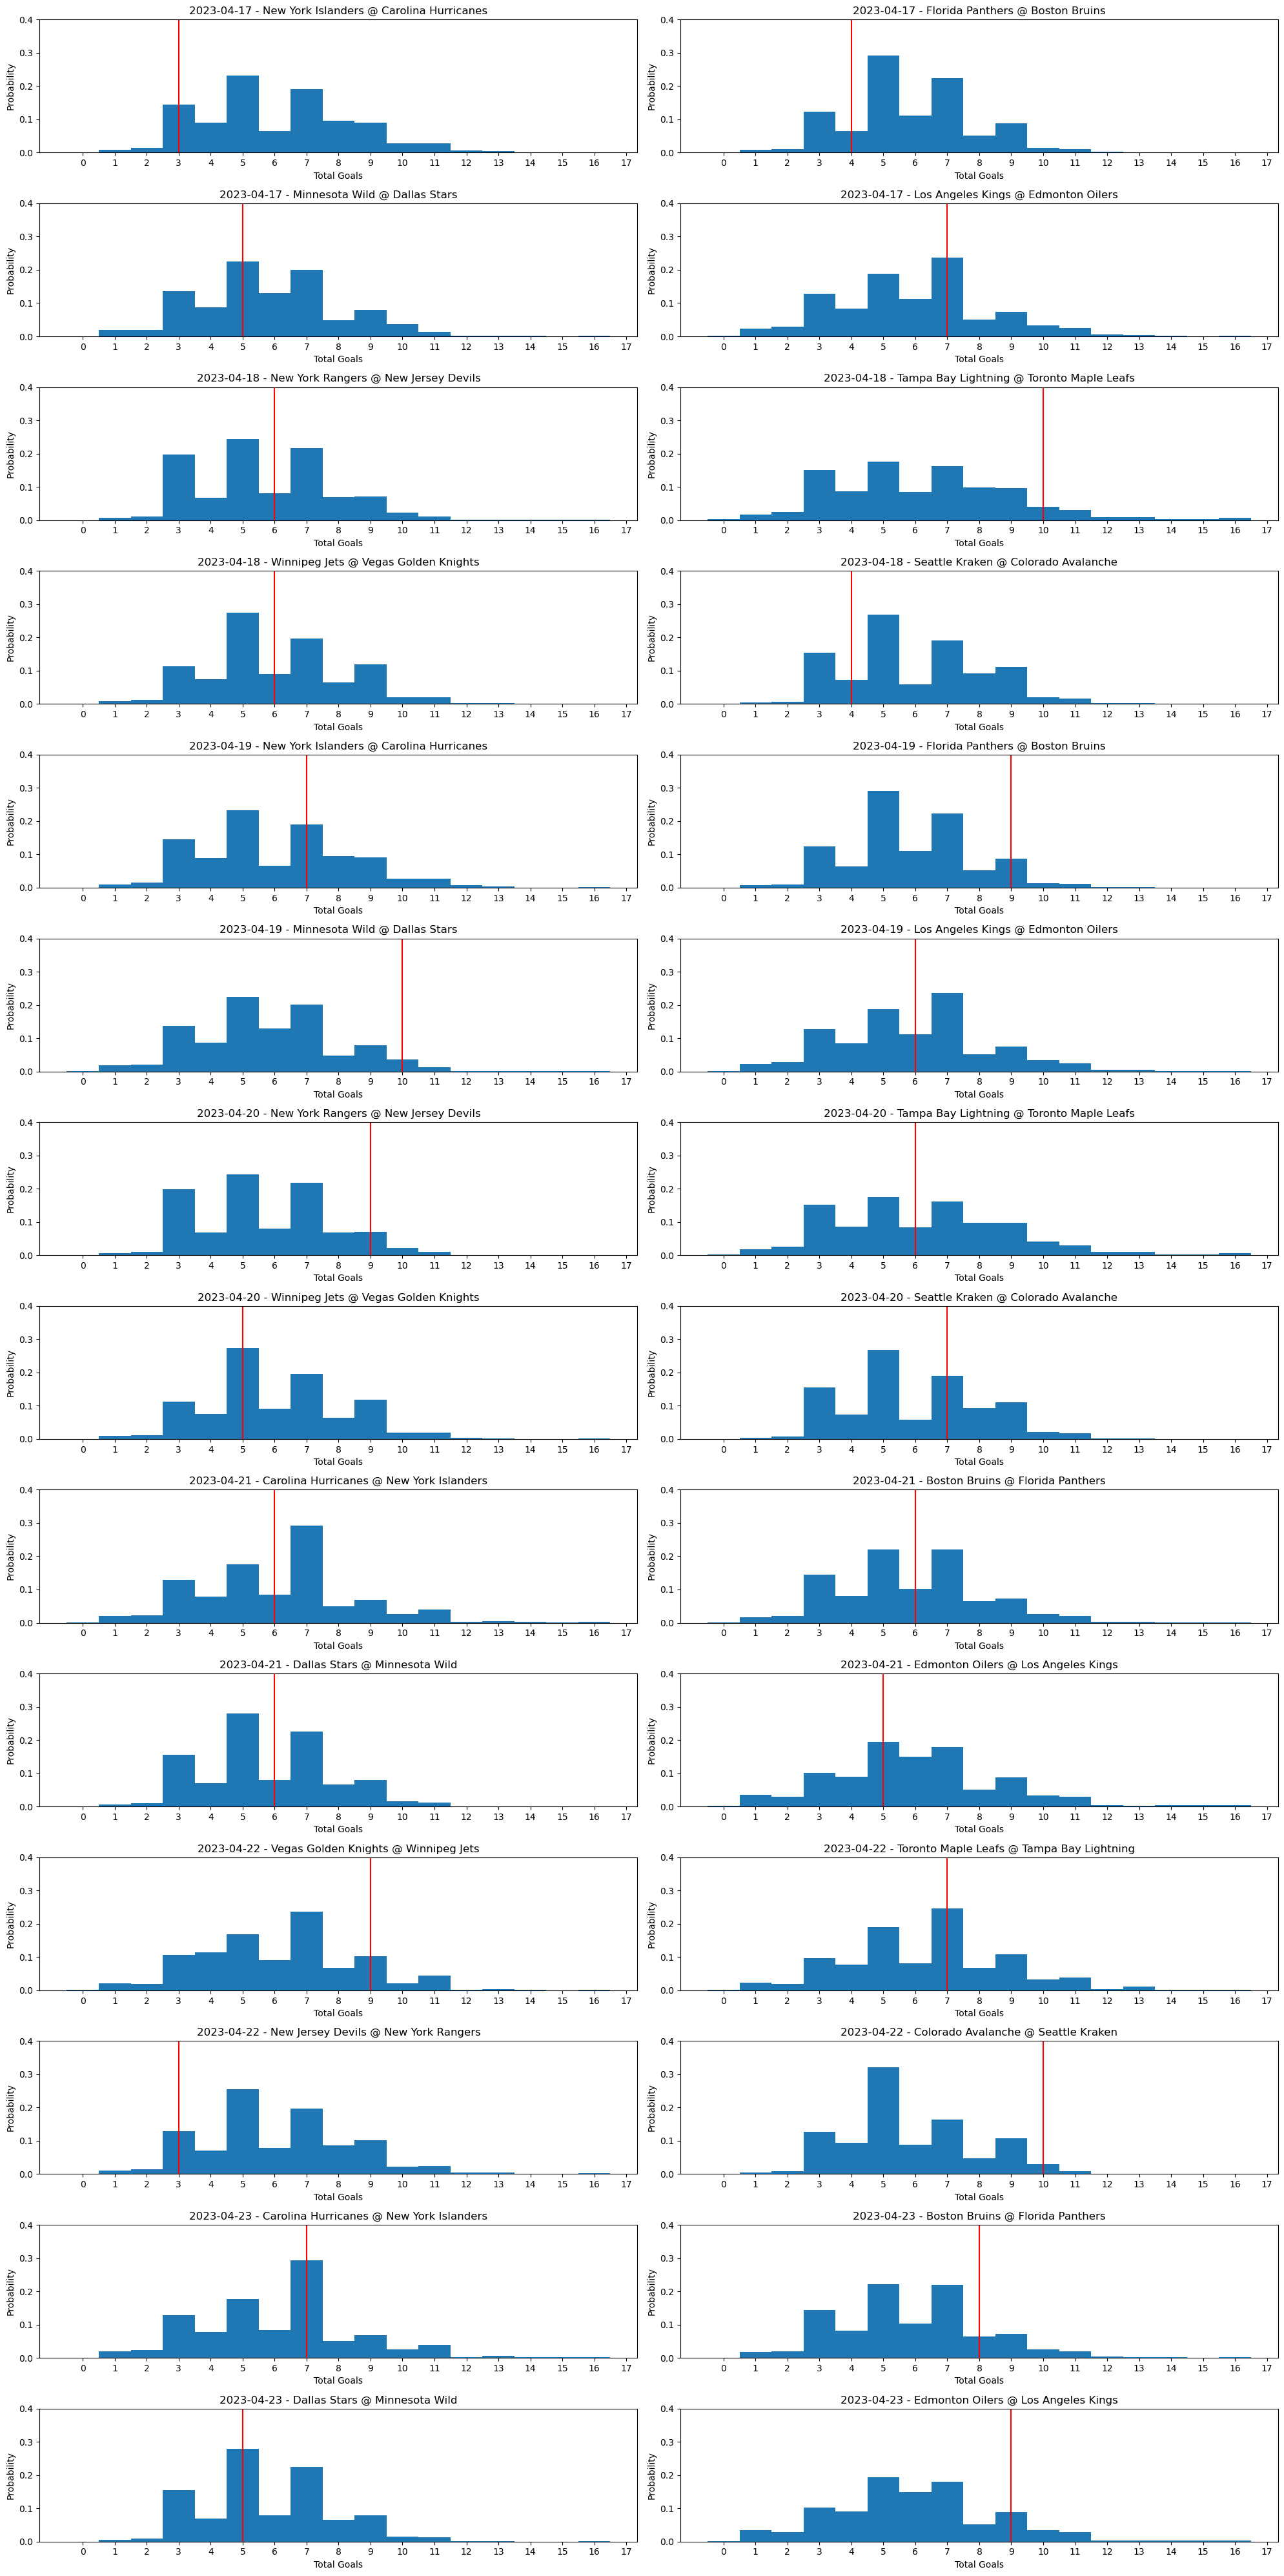

In [65]:
fig, ax = plt.subplots(14,2, figsize=(20,40))

for i in range(len(predicted_goals)):
    goals = range(0,len(predicted_goals[i]))
    preds = predicted_goals[i]
    goal_vals = dict(zip(goals, preds))
    
    date = pd.to_datetime(early_2023_test_data['Timestamp'][i], unit='s').strftime('%Y-%m-%d')
    game = f"{date} - {early_2023_test_data['Visitor'][i]} @ {early_2023_test_data['Home'][i]}"
    
    row, col = divmod(i, 2)  
    ax[row, col].hist(list(goal_vals.keys()), bins=goals, weights=list(goal_vals.values()), align='left')
    ax[row, col].axvline(x=early_2023_test_data['total_goals'][i], color='r')
    ax[row, col].set_xticks(goals)
    ax[row,col].set_title(game)
    ax[row,col].set_xlabel('Total Goals')
    ax[row,col].set_ylabel('Probability')
    ax[row,col].set_ylim(0, 0.4)

fig.tight_layout()

Maybe unsurprisingly, for every game the model predicted 5 and 7 goals as the two most likely outcomes (they were by far the most common regular season outcomes, after all). The interesting result will be where these predicted odds divert significantly from the betting odds. 